In [1]:
from numpy.testing import assert_equal, assert_almost_equal

---

# ACS Final Exam [60 pts]

The exam is divided into 3 sections:

1. Hypothesis Testing [25 pts]


2. Bayesian Statistics [10 pts]


3. Monte Carlo Simulation [25 pts]


<div class="alert alert-block alert-info">
    <b>General Instructions</b>
    <ol>
        <li>Read the instructions and the questions <i>carefully</i>.</li>
        <li>Make sure that your code runs sequentially from <i>top</i> to <i>bottom</i>. Foreshadowing...</li> 
        <li>Follow the prescribed naming conventions.</li>
    </ol>
</div>

---

## Hypothesis Testing  [25 pts]

### Model Comparison with Hypothesis Testing

In this section, we will be looking at a more formal methodology for evaluating models by integrating a hypothesis test to check whether or not the differences between models are *statistically significant*.

<div class="alert alert-block alert-info">
    <b>Instructions</b>
    <ol>
        <li>This section uses the `data.csv` file.</li>
        <li>The nearly equal asserts (hidden and unhidden) in this section have a tolerance of 4 decimal places.</li>
    </ol>
</div>

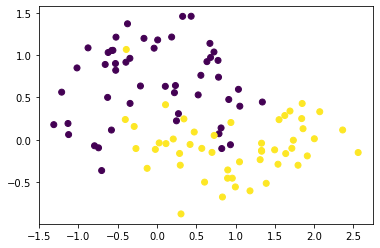

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv')

x = df[['x1', 'x2']].to_numpy()
y = df['y'].to_numpy()

plt.scatter(x=df['x1'], y=df['x2'], c=df['y'])
plt.show()

#### Q1 [10 pts]

Using [`10 repeated stratified 10-fold cross-validation`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html), perform grid-search over the hyperparameter `C` for a SVC with an RBF kernel. 

Set all `random_state` parameters to `143`.

Calculate the mean and standard deviation of the <u>test accuracy scores</u> for each `C` in `C_range`. (use classification accuracy as the metric)

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

C_range = [0.01, 0.1, 1, 10, 100]

random_state = 143

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)

# Put the test accuracy scores every cv split here
test_scores = {} 
n_train = []
n_test = []
for C in C_range:
    test_scores[C] = []
    n_train = []
    n_test = []
    for train_index, test_index in rskf.split(x,y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = SVC(C=C, kernel='rbf', random_state=random_state).fit(x_train, y_train)
        
        
        n_train.append(train_index)
        n_test.append(test_index)
        
        y_pred = model.predict(x_test)
        y_true = y_test
        
        score = accuracy_score(y_true, y_pred)
        
        test_scores[C].append(score)

agg_dict = {}
for k,v in test_scores.items():
    agg_dict[k] = [np.mean(v), np.std(v)]
df_scores = pd.DataFrame(agg_dict).T

        
# Put the mean/std test accuracy scores here
# df_scores = pd.DataFrame(np.zeros(shape=(len(C_range), 2)))
df_scores.columns = ['mean_test_score', 'std_test_score']
# df_scores.index = C_range

# YOUR CODE HERE
# raise NotImplementedError()

# Print out scores
df_scores

,mean_test_score,std_test_score
0.01,0.855,0.120312
0.10,0.874,0.108277
1.00,0.892,0.102645
10.00,0.894,0.100817
100.00,0.870,0.116190


In [4]:
# Sanity check (no points)
for C in C_range:
    assert len(test_scores[C]) == 100

In [5]:
# Check 'mean_test_score' and 'std_test_score' of df_scores.loc[0.01]

In [6]:
# Check 'mean_test_score' and 'std_test_score' of df_scores.loc[0.1]

In [7]:
# Check 'mean_test_score' and 'std_test_score' of df_scores.loc[1]

In [8]:
# Check 'mean_test_score' and 'std_test_score' of df_scores.loc[10]

In [9]:
# Check 'mean_test_score' and 'std_test_score' of df_scores.loc[100]

---

#### No Eyeballin' Here

At this point, most people would rank models based on `mean_test_score`, take the best performer, and call it a day. 

This is eyeballing, and we don't do that in ACS.

Notice that we've calculated the mean and stdev of 100 sample test accuracy scores for each `C`. 

Could we perhaps <u>compare the means between groups</u> using a statistical test? Yes! 

Very Cool.

#### The Problem

Unfortunately, a straight up application of the [`t-test`](https://en.wikipedia.org/wiki/Student%27s_t-test) is inappropriate. Why?

One of the assumptions is that the samples (i.e., the scores) are independent. As it turns out, this is violated because each model is evaluated on the same 100 partitions, which increases the correlation between the scores of the models. 

*Note 1: You can actually check this empirically by calculating the sample correlations between cv splits.*

One way around this is to actually perform Monte Carlo cross-validation instead of k-Fold. Unfortunately, it can be quite computationally expensive to get our accuracy metrics to converge if our dataset is big. While this isn't a problem with our toy dataset, there is a method we can use to bypass this problem.

#### Nadeau and Bengio's Corrected t-Test 

*(Yes, THAT Bengio)*

[`Nadeau and Bengio`](https://papers.nips.cc/paper/1661-inference-for-the-generalization-error.pdf) propose a correction to the pairwise t-test when performing repeated k-Fold. The corrected t-statistic is given by,

$$t = \frac{\frac{1}{kr}\sum_{i=1}^{k}\sum_{j=1}^{r}x_{ij}}{\sqrt{\left(\frac{1}{kr} + \frac{n_\text{test}}{n_\text{train}}\right)\hat{\sigma}^2}}$$

where $k$ is the number of folds, $r$ is the number of reptitions (trials), $x$ is the difference in scores (or whatever metric in general) of the models, $n_\text{test}$ is the number of samples used for testing, $n_\text{train}$ is the number of samples used for training, and $\hat{\sigma}^2$ is the <u>unbiased</u> variance of the observed differences. 

In this instance, the degrees of freedom for the t-statistic is $n - 1$.

*Note 2: $n = kr = n_\text{test} + n_\text{train}$*.

---

#### Q2 [5 pts]

What are the top two models based on `mean_test_score`?

In [10]:
C_1 = 10.00 # Rank 1
C_2 = 1.00 # Rank 2

# YOUR CODE HERE
# raise NotImplementedError()

In [11]:
# Check C_1

In [12]:
# Check C_2

#### Q3 [5 pts]

Suppose we wish to test if the difference between the average test scores of the top two models are statistically significant.

Calculate Nadeau and Bengio's corrected t-statistic. 

Notes: since C10 is > than C1, we want to check if this is statistically significant. So...

nul hypothesis `H0: C10 = C1` <br>
altr hypothesis `H1: C10 > C1`

we would like to reject in favor of the alternative

In [13]:
t_stat = None

k = 10 # of folds
r = 10 # of repetitions

n = k*r
x_diff = (np.array(test_scores[10])-np.array(test_scores[1]))
# x_diff = (np.array(test_scores[1])-np.array(test_scores[10]))

numerator = (1/n) * sum(x_diff)
n_train = 90
n_test = 10

denominator = np.sqrt(((1/n)+(n_test/n_train))*np.var(x_diff, ddof=1))

t_stat = numerator / denominator

# YOUR CODE HERE
# raise NotImplementedError()

In [14]:
t_stat

0.08827502697599406

In [15]:
# Check t_stat

#### Q4 [5 pts]

Calculate the p-value of this statistic.

In [16]:
from scipy.stats import t

p_value = None

p_value = (1 - t.cdf(np.abs(t_stat), df=n-1)) # right tailed
p_value
# YOUR CODE HERE
# raise NotImplementedError()

0.4649182041780664

In [17]:
# Check p_value

#### Epilogue

Given the p-value you just calculated, what can you say about the difference between the top two models?

This question is rhetorical. There are no points to be found here. :^)

---

## Bayesian Statistics [10 pts]

<div class="alert alert-block alert-info">
    <b>Instructions</b>
    <ol>
        <li>The asserts in this section all check for exact equality.</li>
        <li>While I ask you to plot the distributions, the asserts (and your points) are entirely based of the parameters.</li>
    </ol>
</div>

Suppose we wish to model the <u>number of annual insurance claims</u> using a [`Poisson distribution`](https://en.wikipedia.org/wiki/Poisson_distribution) with mean $\lambda$.

Following a Bayesian approach, we also model the prior distribution of $\lambda$ using a [`Gamma distribution`](https://en.wikipedia.org/wiki/Gamma_distribution) with shape and rate parameters $\alpha$ and $\beta$.

We wish to test two priors. The first prior has a mean of $0.5$ and the second prior has a mean of $1.5$.

#### Q1 [5 pts]

Plot the prior distributions and label them appropriately. Set the range of $x$ values to be from $0$ to $5$.

*Hint: Read the documentation of [`scipy.stats.gamma`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) carefully.*

In [18]:
from scipy.stats import gamma

alpha1 = 1
beta1 = 2

alpha2 = 3
beta2 = 2

x_range = np.linspace(0.0,5.0,100)
# YOUR CODE HERE
# raise NotImplementedError()

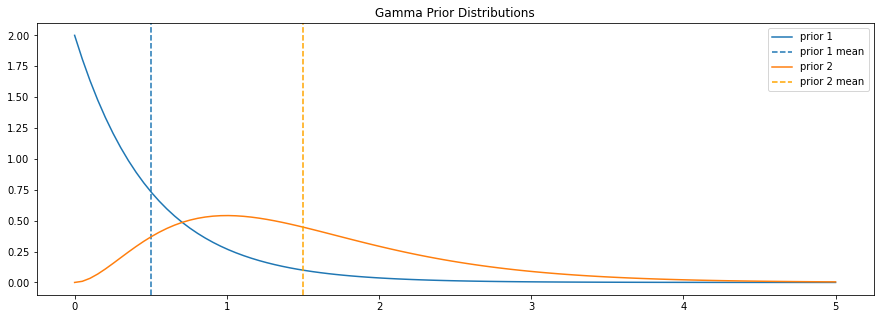

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x_range, gamma.pdf(x_range, a=alpha1, scale=1/beta1), label='prior 1')
ax.axvline(gamma.stats(moments='m', a=alpha1, scale=1/beta1), ls='--', label='prior 1 mean')
ax.plot(x_range, gamma.pdf(x_range, a=alpha2, scale=1/beta2), label='prior 2')
ax.axvline(gamma.stats(moments='m', a=alpha2, scale=1/beta2), ls='--', label='prior 2 mean', color='orange')
plt.title('Gamma Prior Distributions')
plt.legend()
plt.show()

In [20]:
# Check alpha1

In [21]:
# Check beta1

In [22]:
# Check alpha2

In [23]:
# Check beta2

#### Q2 [5 pts]

You observe the following historical claim counts: 1, 3, 3, 0, 0, 7, 2, 2.

Plot the posterior distributions and label them appropriately. Set the range of $x$ values to be from $0$ to $5$.

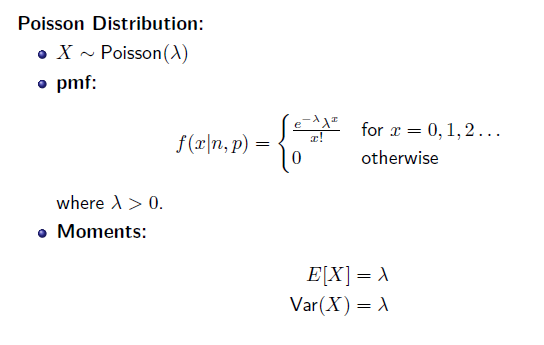

In [24]:
# from sympy import simplify, symbols, exp, factorial
# from math import 
# simplify()

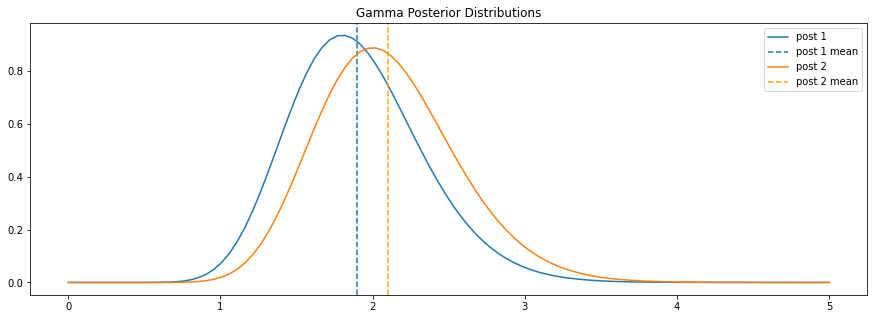

In [25]:
obs = [1,3,3,0,0,7,2,2]
sum_x = sum(obs)
alpha1_post = alpha1 + sum_x
beta1_post = beta1 + len(obs)

alpha2_post = alpha2 + sum_x
beta2_post = beta2 + len(obs)


fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x_range, gamma.pdf(x_range, a=alpha1_post, scale=1/beta1_post), label='post 1')
ax.axvline(gamma.stats(moments='m', a=alpha1_post, scale=1/beta1_post), ls='--', label='post 1 mean')
ax.plot(x_range, gamma.pdf(x_range, a=alpha2_post, scale=1/beta2_post), label='post 2')
ax.axvline(gamma.stats(moments='m', a=alpha2_post, scale=1/beta2_post), ls='--', label='post 2 mean', color='orange')
plt.title('Gamma Posterior Distributions')
plt.legend()
plt.show()
# YOUR CODE HERE
# raise NotImplementedError()

In [26]:
# Check alpha1_post

In [27]:
# Check beta1_post

In [28]:
# Check alpha2_post

In [29]:
# Check beta2_post

---

## Monte Carlo Simulation [25 pts]

### Dungeons & Dragons

This sections presents a collection of D&D related questions. Hopefully, answering them inspires you to play D&D.

Click [`here`](https://media.wizards.com/2018/dnd/downloads/DnD_BasicRules_2018.pdf) to read the free basic rules for 5th Edition D&D. (not required)

<div class="alert alert-block alert-info">
    <b>Instructions</b>
    <ol>
        <li>The questions below are designed to be answered from using a Monte Carlo approach. If you wish, you may attempt to solve them analytically.</li>
        <li>When using Monte Carlo, make sure to set your sample/simulation size to be large enough such that your results are stable.</li>
        <li>Make sure that each cell takes <i>at most</i> 30 seconds to run.</li>
        <li>All asserts (hidden and unhidden) in this section have a tolerance of 2 decimal places.</li>   
    </ol>
</div>

#### Q1 [10 pts] 
*(5 Unhidden, 5 Hidden)*

Recall that:

- An attack will hit if the *attack roll* is equal to or exceeds the target's *armor class* (AC).

- An attack roll is made by rolling a d20 and adding the appropriate *ability modifier* and *proficiency bonus*.

- When rolling with advantage, you may roll the d20 twice and take the higher result.

- Rolling a 1 on the die results in an automatic miss and a rolling a 20 on the die results in an automatic hit (regardless of the attack roll's total).

Suppose that a rogue makes an attack roll with her rapier against a bandit with 15 AC from *stealth*. She has a Dex mod of +4 and a proficiency bonus of +2.

*Note 1: The ability modifier used for a melee weapon attack is Strength, and the ability modifier used for a ranged weapon attack is Dexterity. Weapons that have the finesse or thrown property break this rule.*

*Note 2: Rapiers have the finesse property.*

Attacking from stealth allows the rogue to make the attack roll with *advantage*.

Create a function that can calculate the probability that the rogue's attack will hit the bandit.

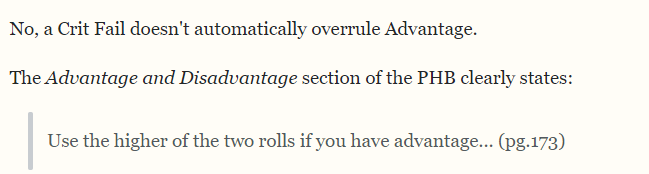

https://rpg.stackexchange.com/questions/71829/does-rolling-a-1-with-advantage-cancel-out-the-higher-roll

In [30]:
# abl_mod = 4
# prof_bonus = 2
# target_ac=15
# advantage = True
# hit = 0
# miss = 0
# n_trials = 1_000
# for _ in range(n_trials):
#     roll_1 = np.random.choice(np.arange(1,21))
#     if advantage:
#         roll_2 = np.random.choice(np.arange(1,21))
#         roll = max(roll_1, roll_2)
#         if roll == 1:
#             miss = miss + 1
#             break
#         elif roll == 20:
#             hit = hit + 1
#             break
#     else:
#         roll = roll_1
#         if roll == 1:
#             miss = miss + 1
#             break
#         elif roll == 20:
#             hit = hit + 1
#             break
#     if (roll + abl_mod + prof_bonus) >= target_ac:
#         hit = hit + 1
#     else:
#         miss = miss + 1
# p_hit = hit/n_trials
# print(hit, miss, p_hit)
# # return p_hit
        

In [31]:
def p_hit(abl_mod=0, prof_bonus=0, target_ac=10, advantage=False):
    res = []
    n_trials = 20_000
    for i in range(n_trials):
#         print('i = ',i)
        roll_1 = np.random.choice(np.arange(1,21))
        if advantage:
            roll_2 = np.random.choice(np.arange(1,21))
            roll = max(roll_1, roll_2)
#             print('roll = ', roll)
            if roll == 1:
#                 print('rolled 1: MISS')
                res.append(0)
#                 print('-----end-----')
                continue
                
            elif roll == 20:
#                 print('rolled 20: HIT')
                res.append(1)
#                 print('-----end-----')
                continue
                
        else:
            roll = roll_1
            if roll == 1:
#                 print('rolled 1: MISS')
                res.append(0)
#                 print('-----end-----')
                continue
                
            elif roll == 20:
#                 print('rolled 20: HIT')
                res.append(1)
#                 print('-----end-----')
                continue
                
#         print('score = ',roll + abl_mod + prof_bonus, end='')
        if (roll + abl_mod + prof_bonus) >= target_ac:
#             print(': HIT')
            res.append(1)
        else:
#             print(': MISS')
            res.append(0)
#         print('-----end-----')
    p_hit = sum(res) / n_trials
#     print(p_hit)
    
    return p_hit

p = p_hit(abl_mod=4, prof_bonus=2, target_ac=15, advantage=True)

print('Probability of a Hit:', p)

Probability of a Hit: 0.83815


In [32]:
assert_almost_equal(p, 0.84, decimal=2)

In [33]:
assert_almost_equal(p_hit(target_ac=30, advantage=False), 0.05, decimal=2)

In [34]:
assert_almost_equal(p_hit(target_ac=1, advantage=False), 0.95, decimal=2)

In [35]:
assert_almost_equal(p_hit(abl_mod=5, prof_bonus=4, target_ac=20, advantage=False), 0.5, decimal=2)

In [36]:
assert_almost_equal(p_hit(abl_mod=8, prof_bonus=4, target_ac=26, advantage=False), 0.349749, decimal=2)

In [37]:
# Hidden Test 1

In [38]:
# Hidden Test 2

In [39]:
# Hidden Test 3

In [40]:
# Hidden Test 4

In [41]:
# Hidden Test 5

#### Q2 [10 pts]
*(5 Unhidden, 5 Hidden)*

A creature that attacks at *disadvantage* must roll the d20 twice and take the lower result.

In addition, a creature may be affected by multiple sources granting it both advantage and disadvantage simulteneously. In this case, the effects cancel each other out and the creature rolls normally.

*Note: This is regardless of the number of sources that grant advantage/disadvantage (i.e., you can't "stack" multiple advantages or disadvantages on yourself).*

Extend the function you created in **Q1** by adding the above features.

In [42]:
def p_hit_2(abl_mod=0, prof_bonus=0, target_ac=10, advantage=False, disadvantage=False):
    res = []
    n_trials = 20_000
    for i in range(n_trials):
#         print('i = ',i)
        
        status = 2*advantage + disadvantage
        
        roll_1 = np.random.choice(np.arange(1,21))
        if status==2:
            roll_2 = np.random.choice(np.arange(1,21))
            roll = max(roll_1, roll_2)
#             print('roll = ', roll)
            if roll == 1:
#                 print('rolled 1: MISS')
                res.append(0)
#                 print('-----end-----')
                continue
                
            elif roll == 20:
#                 print('rolled 20: HIT')
                res.append(1)
#                 print('-----end-----')
                continue
        elif status == 1:
            roll_2 = np.random.choice(np.arange(1,21))
            roll = min(roll_1, roll_2)
#             print('roll = ', roll)
            if roll == 1:
#                 print('rolled 1: MISS')
                res.append(0)
#                 print('-----end-----')
                continue
                
            elif roll == 20:
#                 print('rolled 20: HIT')
                res.append(1)
#                 print('-----end-----')
                continue
                
        elif (status == 0) or (status == 3):
            roll = roll_1
            if roll == 1:
#                 print('rolled 1: MISS')
                res.append(0)
#                 print('-----end-----')
                continue
                
            elif roll == 20:
#                 print('rolled 20: HIT')
                res.append(1)
#                 print('-----end-----')
                continue
                
#         print('score = ',roll + abl_mod + prof_bonus, end='')
        if (roll + abl_mod + prof_bonus) >= target_ac:
#             print(': HIT')
            res.append(1)
        else:
#             print(': MISS')
            res.append(0)
#         print('-----end-----')
    p_hit = sum(res) / n_trials
#     print(p_hit)
    return p_hit
    
    

In [43]:
assert_almost_equal(p_hit_2(4, 2, 15, True, False), p_hit(4, 2, 15, True), decimal=2)

In [44]:
assert_almost_equal(p_hit_2(4, 2, 15, True, True), p_hit(4, 2, 15, False), decimal=2)

In [45]:
assert_almost_equal(p_hit_2(6, 3, 18, False, True), 0.3597554, decimal=2)

In [46]:
assert_almost_equal(p_hit_2(8, 7, 13, False, False), 0.95, decimal=2)

In [47]:
assert_almost_equal(p_hit_2(6, 3, 18, True, True), p_hit_2(6, 3, 18, False, False), decimal=2)

In [48]:
# Hidden Test 1

In [49]:
# Hidden Test 2

In [50]:
# Hidden Test 3

In [51]:
# Hidden Test 4

In [52]:
# Hidden Test 5

#### Q3 [5 pts]

*(3 Unhidden, 2 Hidden)*

Suppose your character, a warlock, has been ambushed in melee by a kobold!

Unfortunately, you are out of spell slots and must use a [`cantrip`](https://roll20.net/compendium/dnd5e/Spells#toc_8) to defend yourself.

You fire off an [`Eldritch Blast`](https://roll20.net/compendium/dnd5e/Eldritch%20Blast#content) at the kobold while in melee. Unfortunately, this means that your attack suffers from *disadvantage*.

For spell attacks, warlocks use their Charisma modifier. Suppose you have a +3 Cha mod and +2 proficiency bonus.

If your attack hits, it deals 1d10 damage. If you roll a 20 on the die (before modifiers), you score a *critical hit*. You get to roll your damage dice a second time (i.e., you roll an *additional* 1d10).

Create a function that can calculate the expected amount of damage dealt to the kobold with 10 AC.

*Note: Don't apply the rounding rule in this case. Can you see why it doesn't apply?*

In [53]:
# For this problem, you can assume that the damage die is always a d10

def expected_dmg(abl_mod=0, prof_bonus=0, target_ac=10, advantage=False, disadvantage=False):
    res = []
    dmg_list = []
    n_trials = 300_000
    for i in range(n_trials):
#         print('i = ',i)
        
        status = 2*advantage + disadvantage
        
        roll_1 = np.random.choice(np.arange(1,21))
        if status==2:
            roll_2 = np.random.choice(np.arange(1,21))
            roll = max(roll_1, roll_2)
#             print('roll = ', roll)
            if roll == 1:
#                 print('rolled 1: MISS')
                res.append(0)
#                 print('-----end-----')
                continue
                
            elif roll == 20:
#                 print('rolled 20: HIT')
                dmg_1 = np.random.choice(np.arange(1,11))
                dmg_2 = np.random.choice(np.arange(1,11))
                dmg = dmg_1 + dmg_2
                res.append(1)
                dmg_list.append(dmg)
#                 print('-----end-----')
                continue
        elif status == 1:
            roll_2 = np.random.choice(np.arange(1,21))
            roll = min(roll_1, roll_2)
#             print('roll = ', roll)
            if roll == 1:
#                 print('rolled 1: MISS')
                res.append(0)
#                 print('-----end-----')
                continue
                
            elif roll == 20:
                dmg_1 = np.random.choice(np.arange(1,11))
                dmg_2 = np.random.choice(np.arange(1,11))
                dmg = dmg_1 + dmg_2 
                dmg_list.append(dmg)
#                 print('rolled 20: HIT')

                res.append(1)
#                 print('-----end-----')
                continue
                
        elif (status == 0) or (status == 3):
            roll = roll_1
            if roll == 1:
#                 print('rolled 1: MISS')
                res.append(0)
#                 print('-----end-----')
                continue
                
            elif roll == 20:
                dmg_1 = np.random.choice(np.arange(1,11))
                dmg_2 = np.random.choice(np.arange(1,11))
                dmg = dmg_1 + dmg_2
                dmg_list.append(dmg)
#                 print('rolled 20: HIT')
                res.append(1)
#                 print('-----end-----')
                continue
                
#         print('score = ',roll + abl_mod + prof_bonus, end='')
        if (roll + abl_mod + prof_bonus) >= target_ac:
#             print(': HIT')
            dmg = np.random.choice(np.arange(1,11))
            dmg_list.append(dmg)
            res.append(1)
        else:
#             print(': MISS')
            res.append(0)
#         print('-----end-----')
    p_hit = sum(res) / n_trials
#     print(p_hit)
    return np.sum(dmg_list) / n_trials

In [54]:
assert_almost_equal(expected_dmg(3, 2, 10, False, True), 3.53, decimal=2)

In [55]:
assert_almost_equal(expected_dmg(3, 2, 1, False, False), 5.5, decimal=2)

In [56]:
assert_almost_equal(expected_dmg(5, 3, 30, True, True), 0.55, decimal=2)

In [57]:
# Hidden Test 1

In [58]:
# Hidden Test 2